Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Spring 2020

### Setup


In [1]:
# modify to where you store your project data including utils
datadir = "./" 

utilfn = datadir + "utils.py"
#!cp "$utilfn" .
imagesfn = datadir + "images"
#!cp -r "$imagesfn" .

In [2]:
#!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
#!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [3]:
def score_projection(pt1, pt2):
    '''
    Score corresponding to the number of inliers for RANSAC
    Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
    Outputs: score (scalar count of inliers) and inliers (1xN logical array)
    '''

  # TO DO
    inliers=np.sqrt((pt1[0,:]-pt2[0,:])**2+(pt1[1,:]-pt2[1,:])**2)<1
    score=sum(inliers)
    return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [4]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO
    n=pts1.shape[1]
    v=np.zeros((2*n,9))
    for i in range(n):
        v[2*i,:3]=-pts1[:,i]
        v[2*i,6:9]=pts1[:,i]*(pts2[0,i]/pts2[2,i])
        v[2*i+1,3:6]=-pts1[:,i]
        v[2*i+1,6:9]=pts1[:,i]*(pts2[1,i]/pts2[2,i])
    H=np.linalg.svd(v)[-1].T[:,-1]
    H=H/H[-1]
    H=H.reshape((3,3))

    return H



    



best score: 161.000000
[[ 1.00000000e+00  5.62504425e-02 -2.05802038e+02]
 [ 1.59664697e-02  9.53229894e-01 -1.69282823e+01]
 [ 4.13998580e-04  8.32312814e-05  7.95401131e-01]]


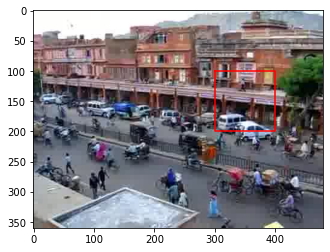

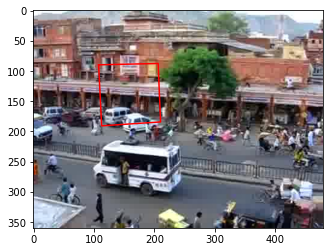

In [5]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2
box_pt2=H@box_pts
for i in range(5):
    box_pt2[:2,i]/=box_pt2[2,i]

plt.figure()
plt.imshow(im2[:,:,[2,1,0]])
plt.plot(box_pt2[0,:], box_pt2[1, :], 'r-')

True

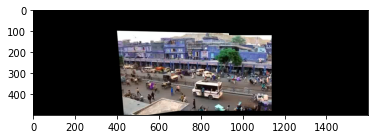

In [6]:
projectedWidth = 1600
projectedHeight = 500
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

# TO DO: warp and blend the two images

iwrp=cv2.warpPerspective(im1,Tr.dot(H),(projectedWidth,projectedHeight))
ibld=np.zeros((projectedHeight,projectedWidth,3))
ibld[:,:,:]=iwrp
ibld[120:120+360,660:660+480,:]=im2
plt.imshow(ibld.astype(np.uint8))
cv2.imwrite('ibld.jpg',ibld)

### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


best score: 204.000000
best score: 163.000000
best score: 138.000000
best score: 102.000000


True

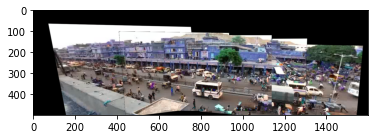

In [7]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
    frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution
projectedWidth = 1600
projectedHeight = 500
Hs=[auto_homography(frames[0],frames[1], computeHomography),
   auto_homography(frames[1],frames[2], computeHomography),
   auto_homography(frames[3],frames[2], computeHomography),
   auto_homography(frames[4],frames[3], computeHomography)]
iwrp=[
    cv2.warpPerspective(frames[0],Tr.dot(Hs[1]@Hs[0]),(projectedWidth,projectedHeight)),
    cv2.warpPerspective(frames[1],Tr.dot(Hs[1]),(projectedWidth,projectedHeight)),
    cv2.warpPerspective(frames[3],Tr.dot(Hs[2]),(projectedWidth,projectedHeight)),
    cv2.warpPerspective(frames[4],Tr.dot(Hs[3]@Hs[2]),(projectedWidth,projectedHeight))]

ibld=np.zeros((projectedHeight,projectedWidth,3))
ibld[120:120+360,660:660+480,:]=frames[2]
ibld+=(ibld==0)*iwrp[1]
ibld+=(ibld==0)*iwrp[0]
ibld+=(ibld==0)*iwrp[2]
ibld+=(ibld==0)*iwrp[3]

plt.imshow(ibld.astype(np.uint8))
cv2.imwrite('ipnrm.jpg',ibld)

### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [9]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)



In [9]:
# TO DO part 3 solution

# create your video (see tips)

key_frames_idx = np.array([90, 270, 450, 630, 810])-1

keyframes = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
    keyframes[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

projectedWidth = 1600
projectedHeight = 500
KHs=[auto_homography(keyframes[0],keyframes[1], computeHomography),
   auto_homography(keyframes[1],keyframes[2], computeHomography),
   auto_homography(keyframes[3],keyframes[2], computeHomography),
   auto_homography(keyframes[4],keyframes[3], computeHomography)]
Kiwrp=[
    cv2.warpPerspective(keyframes[0],Tr.dot(KHs[1]@KHs[0]),(projectedWidth,projectedHeight)),
    cv2.warpPerspective(keyframes[1],Tr.dot(KHs[1]),(projectedWidth,projectedHeight)),
    cv2.warpPerspective(keyframes[3],Tr.dot(KHs[2]),(projectedWidth,projectedHeight)),
    cv2.warpPerspective(keyframes[4],Tr.dot(KHs[3]@KHs[2]),(projectedWidth,projectedHeight))]

IH=[KHs[1]@KHs[0],KHs[1],KHs[2],KHs[3]@KHs[2]]

Hflst=[]

for i in range(180):
    H=auto_homography(frames[i],keyframes[0],computeHomography)
    Hflst.append(IH[0]@H)
    iwrp=cv2.warpPerspective(frames[i],Tr.dot(IH[0]@H),(projectedWidth,projectedHeight))
    cv2.imwrite('p3_cache/iwrp{:05d}.jpg'.format(i),iwrp)

for i in range(180,360):
    H=auto_homography(frames[i],keyframes[1],computeHomography)
    Hflst.append(IH[1]@H)
    iwrp=cv2.warpPerspective(frames[i],Tr.dot(IH[1]@H),(projectedWidth,projectedHeight))
    cv2.imwrite('p3_cache/iwrp{:05d}.jpg'.format(i),iwrp)

for i in range(360,540):
    H=auto_homography(frames[i],keyframes[2],computeHomography)
    Hflst.append(H)
    iwrp=cv2.warpPerspective(frames[i],Tr.dot(H),(projectedWidth,projectedHeight))
    cv2.imwrite('p3_cache/iwrp{:05d}.jpg'.format(i),iwrp)

for i in range(540,720):
    H=auto_homography(frames[i],keyframes[3],computeHomography)
    Hflst.append(IH[2]@H)
    iwrp=cv2.warpPerspective(frames[i],Tr.dot(IH[2]@H),(projectedWidth,projectedHeight))
    cv2.imwrite('p3_cache/iwrp{:05d}.jpg'.format(i),iwrp)

for i in range(720,900):
    H=auto_homography(frames[i],keyframes[4],computeHomography)
    Hflst.append(IH[3]@H)
    iwrp=cv2.warpPerspective(frames[i],Tr.dot(IH[3]@H),(projectedWidth,projectedHeight))
    cv2.imwrite('p3_cache/iwrp{:05d}.jpg'.format(i),iwrp)

best score: 213.000000
best score: 164.000000
best score: 146.000000
best score: 95.000000
best score: 365.000000
best score: 371.000000
best score: 375.000000
best score: 373.000000
best score: 392.000000
best score: 384.000000
best score: 406.000000
best score: 395.000000
best score: 412.000000
best score: 423.000000
best score: 431.000000
best score: 402.000000
best score: 417.000000
best score: 412.000000
best score: 428.000000
best score: 422.000000
best score: 433.000000
best score: 439.000000
best score: 424.000000
best score: 414.000000
best score: 417.000000
best score: 427.000000
best score: 431.000000
best score: 437.000000
best score: 453.000000
best score: 435.000000
best score: 415.000000
best score: 447.000000
best score: 446.000000
best score: 440.000000
best score: 449.000000
best score: 446.000000
best score: 463.000000
best score: 458.000000
best score: 431.000000
best score: 452.000000
best score: 456.000000
best score: 451.000000
best score: 448.000000
best score: 

best score: 222.000000
best score: 196.000000
best score: 198.000000
best score: 209.000000
best score: 208.000000
best score: 198.000000
best score: 211.000000
best score: 237.000000
best score: 241.000000
best score: 247.000000
best score: 250.000000
best score: 220.000000
best score: 232.000000
best score: 219.000000
best score: 215.000000
best score: 237.000000
best score: 246.000000
best score: 224.000000
best score: 265.000000
best score: 238.000000
best score: 245.000000
best score: 278.000000
best score: 254.000000
best score: 199.000000
best score: 249.000000
best score: 242.000000
best score: 224.000000
best score: 222.000000
best score: 228.000000
best score: 219.000000
best score: 236.000000
best score: 248.000000
best score: 244.000000
best score: 252.000000
best score: 243.000000
best score: 235.000000
best score: 254.000000
best score: 267.000000
best score: 259.000000
best score: 245.000000
best score: 247.000000
best score: 280.000000
best score: 313.000000
best score:

best score: 175.000000
best score: 172.000000
best score: 170.000000
best score: 155.000000
best score: 151.000000
best score: 171.000000
best score: 150.000000
best score: 150.000000
best score: 163.000000
best score: 134.000000
best score: 168.000000
best score: 179.000000
best score: 167.000000
best score: 184.000000
best score: 183.000000
best score: 182.000000
best score: 184.000000
best score: 186.000000
best score: 197.000000
best score: 183.000000
best score: 193.000000
best score: 183.000000
best score: 187.000000
best score: 202.000000
best score: 216.000000
best score: 163.000000
best score: 200.000000
best score: 203.000000
best score: 185.000000
best score: 192.000000
best score: 176.000000
best score: 195.000000
best score: 211.000000
best score: 207.000000
best score: 253.000000
best score: 210.000000
best score: 193.000000
best score: 191.000000
best score: 198.000000
best score: 194.000000
best score: 194.000000
best score: 157.000000
best score: 179.000000
best score:

/home/humanoid/o-conda/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide


best score: 185.000000
best score: 198.000000
best score: 188.000000
best score: 189.000000
best score: 163.000000
best score: 199.000000
best score: 199.000000
best score: 200.000000
best score: 187.000000
best score: 174.000000
best score: 186.000000
best score: 192.000000
best score: 174.000000
best score: 187.000000
best score: 195.000000
best score: 183.000000
best score: 193.000000
best score: 176.000000
best score: 172.000000
best score: 202.000000
best score: 163.000000
best score: 171.000000
best score: 187.000000
best score: 159.000000
best score: 166.000000
best score: 163.000000
best score: 165.000000
best score: 165.000000
best score: 140.000000
best score: 159.000000
best score: 160.000000
best score: 150.000000
best score: 183.000000
best score: 173.000000
best score: 167.000000
best score: 177.000000
best score: 139.000000
best score: 158.000000


In [10]:
utils.imageFolder2mpeg('p3_cache/',output_path='part3.mpeg')

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


/home/humanoid/o-conda/anaconda3/envs/py3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/humanoid/o-conda/anaconda3/envs/py3.7/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


True

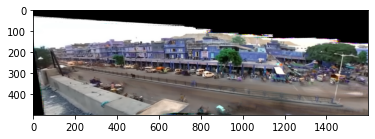

In [10]:
# TO DO part 4
import os 
dir_frames = 'p3_cache'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)

bg=np.zeros((projectedHeight,projectedWidth,3))
for i in range(projectedHeight):
    for j in range(projectedWidth):
        for c in range(3):
            bg[i,j,c]=np.median(frames[np.nonzero(frames[:,i,j,c]),i,j,c]) if len(np.nonzero(frames[:,i,j,c]))>0 else 0

plt.imshow(bg.astype(np.uint8))
cv2.imwrite('part4.jpg',bg)

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [12]:
# TO DO part 5

import os 
dir_frames = 'p3_cache'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)

bg=np.zeros((projectedHeight,projectedWidth,3))
for i in range(projectedHeight):
    for j in range(projectedWidth):
        for c in range(3):
            if len(np.nonzero(frames[:,i,j,c]))>0:
                bg[i,j,c]=np.median(frames[np.nonzero(frames[:,i,j,c]),i,j,c])
                frames[np.nonzero(frames[:,i,j,c]),i,j,c]=bg[i,j,c]

for i,frame in enumerate(frames):
    cv2.imwrite('p5_cache/iwrp{:05d}.jpg'.format(i),frame)

In [ ]:
utils.imageFolder2mpeg('p5_cache/',output_path='part5.mpeg')

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6
import os
import multiprocessing as mp
dir_frames = 'p3_cache'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
framesfl = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    framesfl[idx] = cv2.imread(file_i)

dir_frames = 'p5_cache'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
framesbg = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    framesbg[idx] = cv2.imread(file_i)


for i in range(900):
    diff=framesfl[i]-framesbg[i]
    diff=np.sqrt(diff[:,:,0]**2 + diff[:,:,1]**2 + diff[:,:,2]**2)
    idx=np.argwhere(diff>0.005)
    fg=np.zeros((frameHeight,frameWidth,3))
    fg[idx[:,0],idx[:,1],:]=1
    fg=framesfl*fg
    cv2.imwrite('p6_cache/iwrp{:05d}.jpg'.format(i),fg)


## Bells and whistles